In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import stats_support as stats

sns.set_theme()

Prepare data

In [ ]:

recovered_old = stats.readData("benchmark-stats-2025-04-09-amb-pruning-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-19-parent-amb-3-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-2-rascal-0-10240.txt.gz")
#recovered = stats.readData("benchmark-stats-2025-04-23-parent-amb-any-3-rascal-0-10240.txt.gz")
recovered = stats.readData("benchmark-stats-2025-04-29-flattener-amb-filter-rascal-0-5120maxamb-2.txt.gz")


### Visualize the recovery duration per file size bucket using a violing graph.

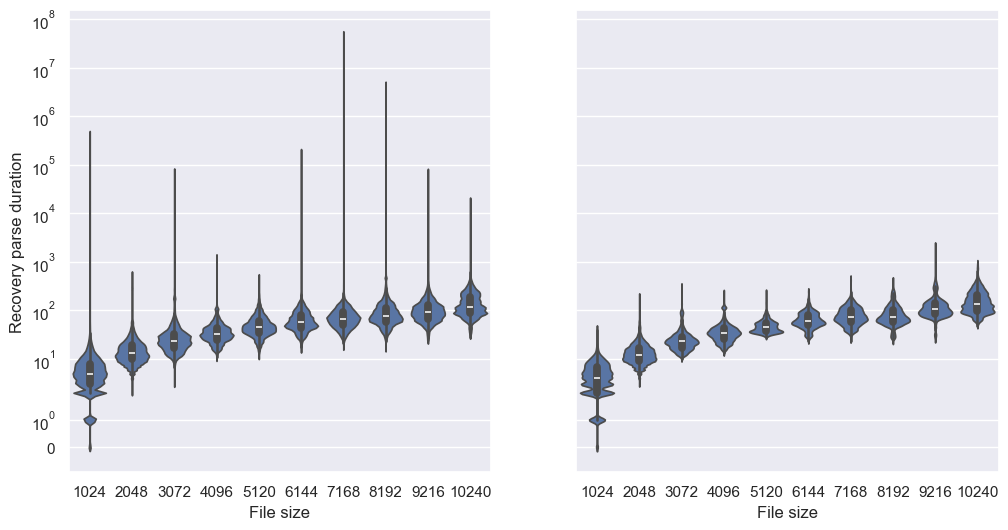

In [10]:
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax1[0].set_yscale('symlog')

sns.violinplot(
    data=recovered_old,
    x="bsize", y="duration",
    density_norm="width",
    ax = ax1[0]
)

sns.violinplot(
    data=recovered,
    x="bsize", y="duration",
    density_norm="width",
    ax = ax1[1]
)

for i in range(2):
    #grouped.plot(x="bsize", y="duration", ax=ax1[i], color="green", label="Regular parse duration")
    ax1[i].set_xlabel("File size")

ax1[0].set_ylabel("Recovery parse duration")


plt.show(fig1)

### Node distribution per file size

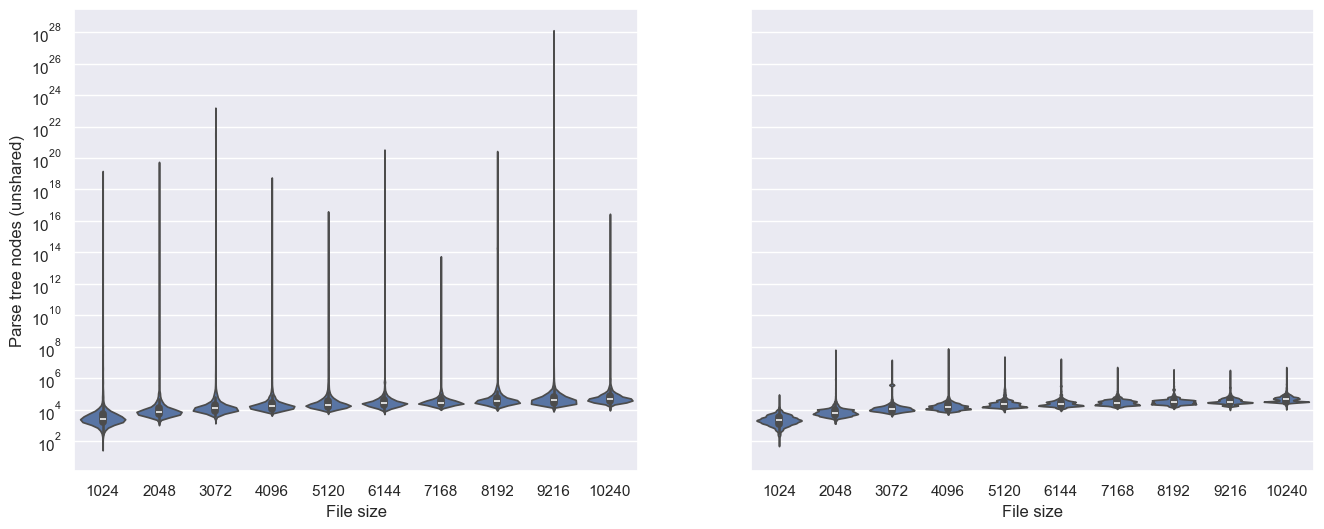

In [5]:
fig2, ax2 = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax2[0].set_yscale('symlog')
ax2[0].set_ylabel("Parse tree nodes (unshared)")
 
sns.violinplot(
    data=recovered_old,
    x="bsize", y="nodes",
    density_norm="width",
    ax=ax2[0]
)
sns.violinplot(
    data=recovered,
    x="bsize", y="nodes",
    density_norm="width",
    ax=ax2[1]
)

for i in range(2):
    #grouped.plot(x="bsize", y="nodes", ax=ax2[i], color="green", label="Regular parse nodes")
    ax2[i].set_xlabel("File size")

plt.show(fig2)

### Max node counts per amb pruning level

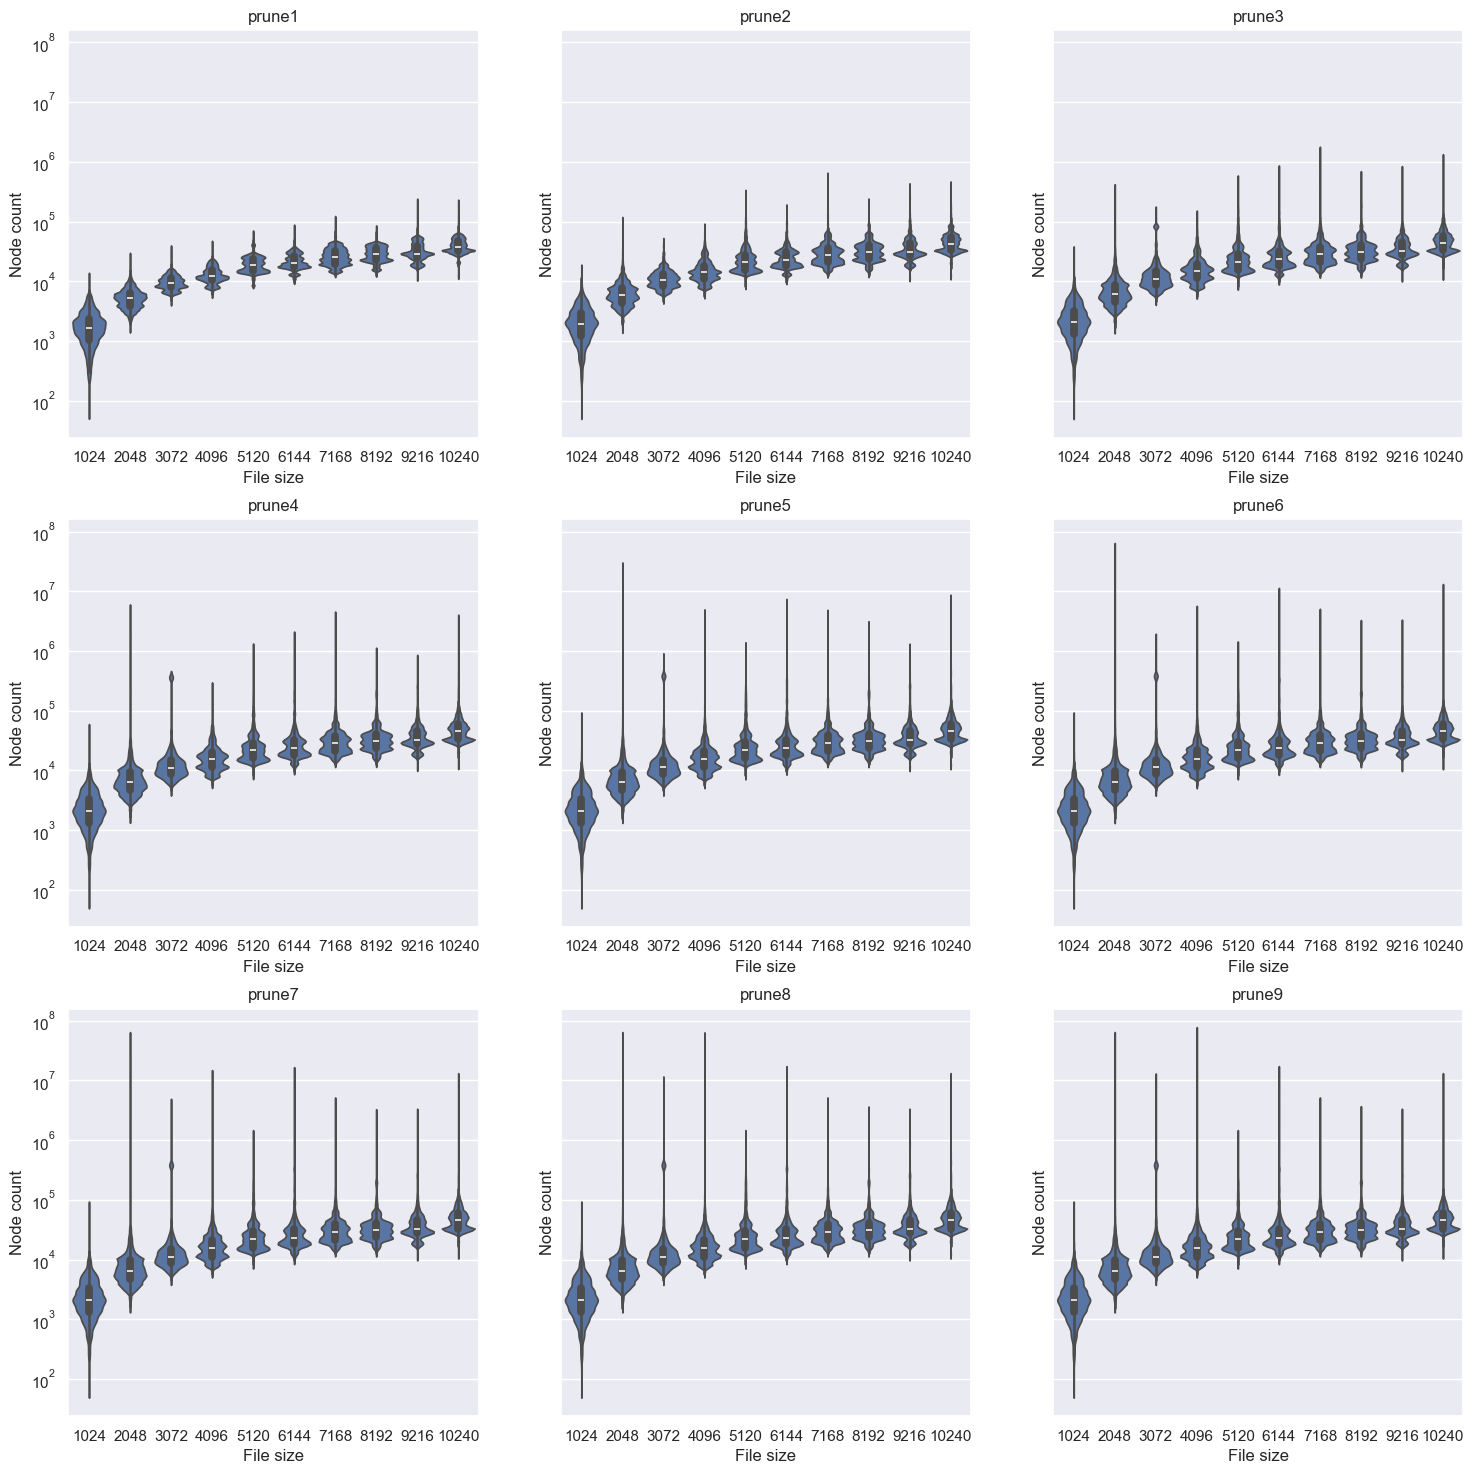

In [11]:
pruneFig, pruneAx = plt.subplots(3, 3, figsize=(18, 18), sharey=True)

for row in range(3):
    for col in range(3):
        idx = row*3+col+1
        name = "prune" + str(idx)
        pruneAx[row][col].set_title(name)
        pruneAx[row][col].set_xlabel("File size")
        pruneAx[row][col].set_ylabel("Node count")
        pruneAx[row][col].set_yscale('symlog')
        sns.violinplot(data=recovered, x="bsize", y=name, density_norm="width", ax=pruneAx[row][col])

plt.show(pruneFig)


### Parse ratio vs file size

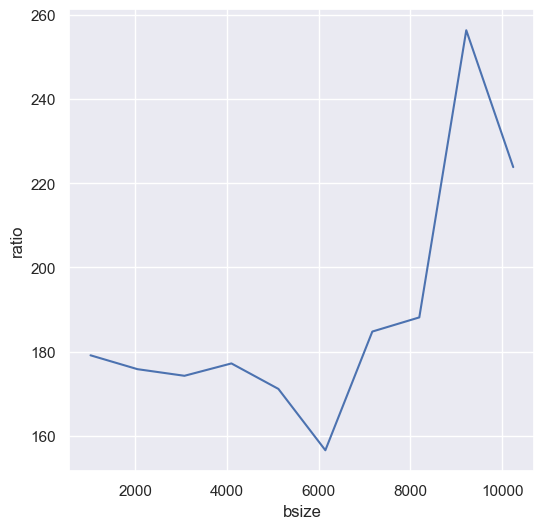

In [7]:
ratioFig, ratioAx = plt.subplots(figsize=(6, 6))
grouped = recovered.groupby("bsize", observed=True).agg({"ratio": "mean", "nodes": "mean"}).reset_index()
sns.lineplot(data=grouped, x="bsize", y="ratio", ax=ratioAx)
plt.show(ratioFig)


